# Center of charge mapping

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [9]:
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids = np.array(conversion_ids['CdID'])
    pmt_ids = np.array(conversion_ids['PMTID'])
    mask = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

## Load data

In [10]:
# PMT positions on the sphere
PMTPos_CD_LPMT    = pd.read_csv("../data/PMTPos_CD_LPMT.csv")
PMTPos_CD_LPMT.rename({"PMTID":"id"}, axis=1, inplace=True)
# PMT ID mapping
PMT_ID_conversion = pd.read_csv("../data/PMT_ID_conversion.csv")

# EVENTS
train_data        = np.load("../data/real/train/data/raw_data_train_4.npz", allow_pickle=True)["a"]
# TRUE ENERGY AND TRUE VERTEX OF THE EVENTS
train_label       = pd.read_csv("../data/real/train/targets/targets_train_4.csv")

# COMPUTE RADIUS FROM TRUE VERTEX
train_label["edepR"] = (train_label["edepX"]**2 + train_label["edepY"]**2 + train_label["edepZ"]**2)**0.5



\begin{equation}
{\displaystyle R_{xyz(?)}={\begin{pmatrix}\sin \theta \cos \varphi &\sin \theta \sin \varphi &\cos \theta \\\cos \theta \cos \varphi &\cos \theta \sin \varphi &-\sin \theta \\-\sin \varphi &\cos \varphi &0\end{pmatrix}}.}
\end{equation}




## Create a dataframe with cc in the origin

In [11]:
def R_z(theta):
    Rot = np.array([[np.cos(theta), -np.sin(theta),0],
                [np.sin(theta), np.cos(theta),0],
                [0, 0, 1]])
    return Rot

def R_x(theta):
    Rot = np.array([[1,0,0],
                [0,np.cos(theta), -np.sin(theta)],
                [0, np.sin(theta), np.cos(theta)]])
    return Rot

def R_xz(phi,theta):
    R = np.matmul(R_x(phi), R_z(theta))
    return R
    

def R_yz(theta_rot, phi_rot):
    Rot = np.array([[np.cos(phi_rot)*np.cos(theta_rot), -np.sin(phi_rot)*np.cos(theta_rot), np.sin(theta_rot)],
                     [np.sin(phi_rot), np.cos(phi_rot), 0],
                     [-np.sin(theta_rot)*np.cos(phi_rot), np.sin(theta_rot)*np.sin(phi_rot), np.cos(theta_rot)]])
    return Rot

In [12]:
def R1(theta):
    Rot = [np.array([[np.sin(theta[i]), -np.cos(theta[i]),0],
                [np.cos(theta[i]), np.sin(theta[i]),0],
                [0, 0, 1]])
    for i in range(len(theta))]
    return Rot

def R2(theta, theta_rot):
    Rot = [np.array([[1,0,0],
                [0,np.cos(theta_rot[i]-theta[i]), -np.sin(theta_rot[i]-theta[i])],
                [0, np.sin(theta_rot[i]-theta[i]), np.cos(theta_rot[i]-theta[i])]])
                for i in range(len(theta))]
    return Rot

def Rotation(phi_old, theta_old, phi_rot, theta_rot):
    return [np.matmul(R1(phi_rot)[i], R2(theta_old,theta_rot)[i], R1(phi_old)[i]) for i in range(len(theta_old))]



In [28]:
#R = 19387.6557
Nevents = train_data.shape[1]
cc_df = pd.DataFrame(columns=['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new', 'charge', 'hit_time'])
ev_dfs = []

for i in tqdm(range(Nevents)):
    # find non-zero-time hits
    nonzeros_inds = np.where(train_data[2, i] != 0.0)[0]

    ev_df = pd.DataFrame(columns=['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new', 'charge', 'hit_time'])
    ev_df['ev_id'] = pd.Series(np.repeat(i, len(nonzeros_inds)))
    # PMT ID mapping
    ev_df['pmt_id'] = pd.Series(convert_pmt_ids(train_data[0, i][nonzeros_inds], PMT_ID_conversion)) 


    coord = PMTPos_CD_LPMT[np.isin(PMTPos_CD_LPMT.id, ev_df['pmt_id'])].loc[:, ['x', 'y', 'z']].reset_index(drop=True)

    ev_df['x'] = coord['x']
    ev_df['y'] = coord['y']
    ev_df['z'] = coord['z']
    
    tot_charge = np.sum(train_data[1, i][nonzeros_inds])
    x_cc = np.sum(coord['x']*train_data[1, i][nonzeros_inds]) / tot_charge
    y_cc = np.sum(coord['y']*train_data[1, i][nonzeros_inds]) / tot_charge
    z_cc = np.sum(coord['z']*train_data[1, i][nonzeros_inds]) / tot_charge

    # go to polar coordinates
    theta_cc = np.arctan2(np.sqrt((x_cc)**2+(y_cc)**2) , z_cc)
    phi_cc   = np.arctan2(y_cc, x_cc) 
    #print('ev', i, '\tR_cc:', np.sqrt(x_cc**2+y_cc**2+z_cc**2), 
    #      '\nx_cc:', x_cc, '\t:y_cc:', y_cc, '\tz_cc:', z_cc, 
    #      '\ntheta_cc:', theta_cc, '\tphi_cc:', phi_cc)

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    '''
    if(theta_rot > np.pi and theta_rot < 2*np.pi):
        theta_rot = 2*np.pi - theta_rot
        phi_rot   = phi_rot + np.pi
    elif(theta_rot < 0 and theta_rot > -np.pi):
        theta_rot = -theta_rot
        phi_rot   = phi_rot + np.pi
  
    theta_new = np.arctan2(np.sqrt(coord['x']**2+coord['y']**2) , coord['z']) #- theta_cc #+ np.pi/2   # +pi/2 - pi
    phi_new   = np.arctan2(coord['x'], coord['y']) - phi_cc
    '''
    #phi_old   = np.arctan2(coord['x'], coord['y'])
    #theta_old = np.arctan2(np.sqrt(coord['x']**2+coord['y']**2) , coord['z'])
    coord_new = np.matmul(R_yz(theta_rot, phi_rot), coord.T)

    ev_df['x_new'] = coord_new.loc[0]
    ev_df['y_new'] = coord_new.loc[1]
    ev_df['z_new'] = coord_new.loc[2]
    
    ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
    ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])

    ev_dfs.append(ev_df)
    

cc_df = pd.concat(ev_dfs, ignore_index=True)

100%|██████████| 5000/5000 [01:07<00:00, 74.41it/s]


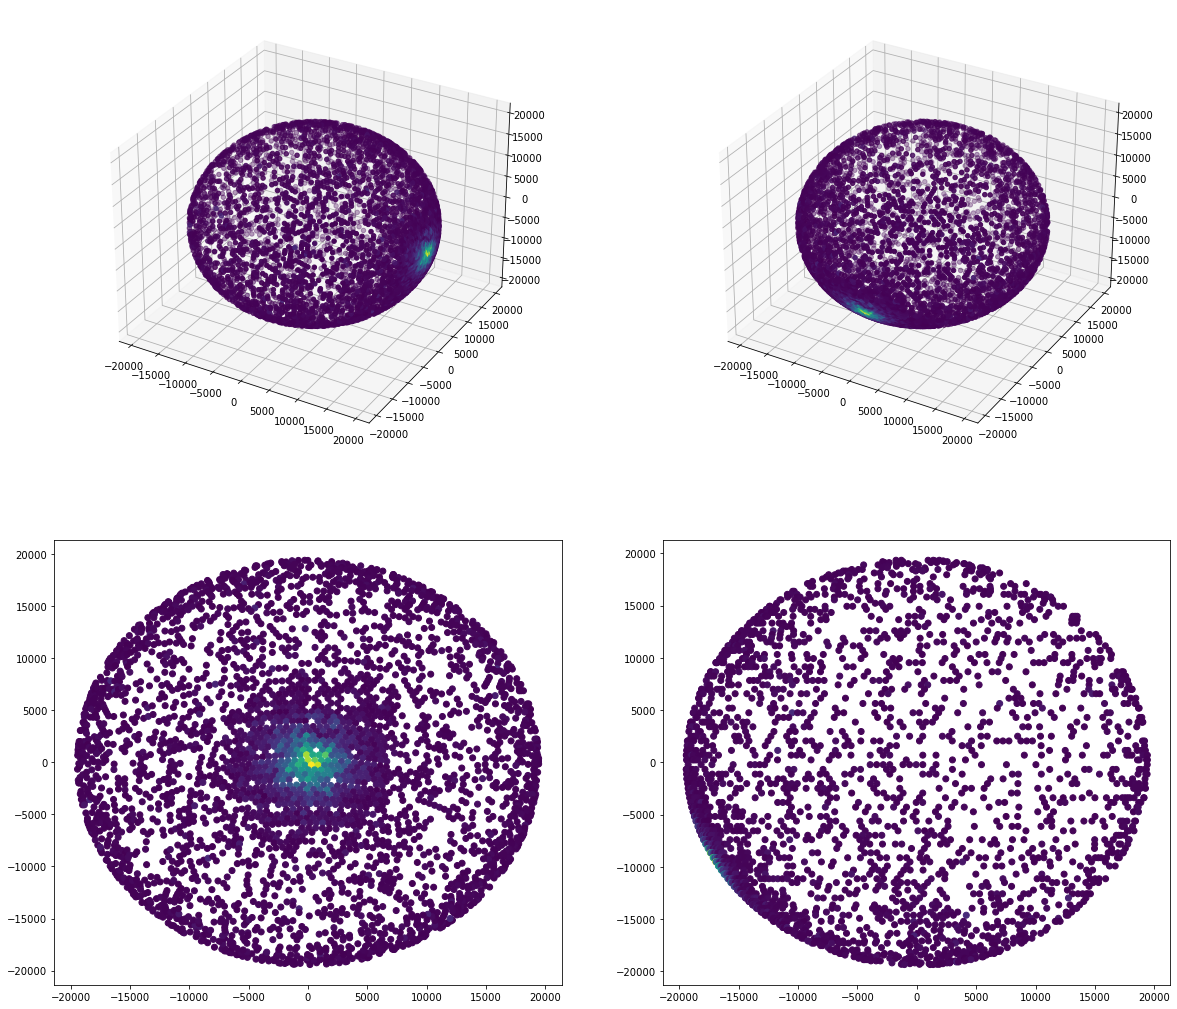

In [33]:
# for i in range(20):
i=2
fig = plt.figure(figsize=(20,18))
axr = fig.add_subplot(221, projection='3d')

axr.scatter(
    xs = cc_df[cc_df.ev_id==i]['x_new'],
    ys = cc_df[cc_df.ev_id==i]['y_new'],
    zs = cc_df[cc_df.ev_id==i]['z_new'],
    c  = cc_df[cc_df.ev_id==i]['charge']
)
# axr.set_zlim(-3e4, 3e4)

axr2d = fig.add_subplot(223)
ev = cc_df[cc_df.ev_id==i]
maskr = ev.x_new > 0
axr2d.scatter(
    x = ev['y_new'][maskr],
    y = ev['z_new'][maskr],
    c = ev['charge'][maskr]
)

axo = fig.add_subplot(222, projection='3d')
axo.scatter(
    xs = cc_df[cc_df.ev_id==i]['x'],
    ys = cc_df[cc_df.ev_id==i]['y'],
    zs = cc_df[cc_df.ev_id==i]['z'],
    c  = cc_df[cc_df.ev_id==i]['charge']

)

masko = ev.x > 0
axo2d = fig.add_subplot(224)
axo2d.scatter(
    x = ev['y'][masko],
    y = ev['z'][masko],
    c = ev['charge'][masko]
)

plt.show()

## Mapping cc data to 2D images

In [132]:
#R = 19387.6557
Nevents = train_data.shape[1]

images_mat = np.zeros(shape=(Nevents, 124, 230, 2))
pmt_pos    = PMTPos_CD_LPMT.copy()
#z_levels   = pmt_pos["z"].round().unique()

N_max = 115

error_ls = []
for i in tqdm(range(Nevents)):
    # find non-zero-time hits
    nonzeros_inds = np.where(train_data[2, i] != 0.0)[0]

    ev_df = pd.DataFrame(columns=['x_new', 'y_new', 'z_new', 'R','charge', 'hit_time'])

    pmt_ids = convert_pmt_ids(train_data[0, i][nonzeros_inds], PMT_ID_conversion)
    coord = PMTPos_CD_LPMT[np.isin(PMTPos_CD_LPMT.id, pmt_ids)].loc[:, ['x', 'y', 'z']].reset_index(drop=True)

    tot_charge = np.sum(train_data[1, i][nonzeros_inds])
    x_cc = np.sum(coord['x']*train_data[1, i][nonzeros_inds]) / tot_charge
    y_cc = np.sum(coord['y']*train_data[1, i][nonzeros_inds]) / tot_charge
    z_cc = np.sum(coord['z']*train_data[1, i][nonzeros_inds]) / tot_charge

    # go to polar coordinates
    theta_cc = np.arctan2(np.sqrt((x_cc)**2+(y_cc)**2) , z_cc)
    phi_cc   = np.arctan2(y_cc, x_cc) 

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc

    coord_new = np.matmul(R_yz(theta_rot, phi_rot), coord.T)

    ev_df['x_new'] = coord_new.loc[0]
    ev_df['y_new'] = coord_new.loc[1]
    ev_df['z_new'] = coord_new.loc[2]
    ev_df['R']     = np.sqrt(coord_new.loc[0]**2 + coord_new.loc[1]**2 + coord_new.loc[2]**2)
 
       
    ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
    ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])

    
    '''
    MAPPING
    '''
    
    errors = 0
    z_levels, step = np.linspace(ev_df['z_new'].min(), ev_df['z_new'].max(), 124, retstep=True)
    for j, z in enumerate(z_levels):
        mask = (np.abs(ev_df.z_new - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
        if(not np.any(mask)): continue
        masked = ev_df[mask]
        
        R = masked.R.mean()
        
        Rz = R**2 - z**2
        if Rz < 0:
            Neff = 0
            errors = errors + 1
        else:
            Neff = N_max * np.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = np.around( Neff * (np.arctan2(masked.y_new.to_numpy(), masked.x_new.to_numpy()) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)

        corr_mask = np.where(ix >= 230)
        if(np.any(corr_mask)):
            ix[corr_mask] = ix[corr_mask] - 230
        
        images_mat[i, j, ix,] = masked[['charge','hit_time']]

        # if np.isnan(mat[ix, i+1]):
        #     mat[ix, i+1] = row.id
        # else:
        #     mat[ix, 123 if i else i] = row.id

    del ev_df
    error_ls.append(errors)


  1%|          | 32/5000 [00:04<12:28,  6.64it/s]


KeyboardInterrupt: 

In [100]:
print(z_levels.max(), z_levels.min())
pmt_pos["z"].min()

19413.0 -19429.0


-19365.0

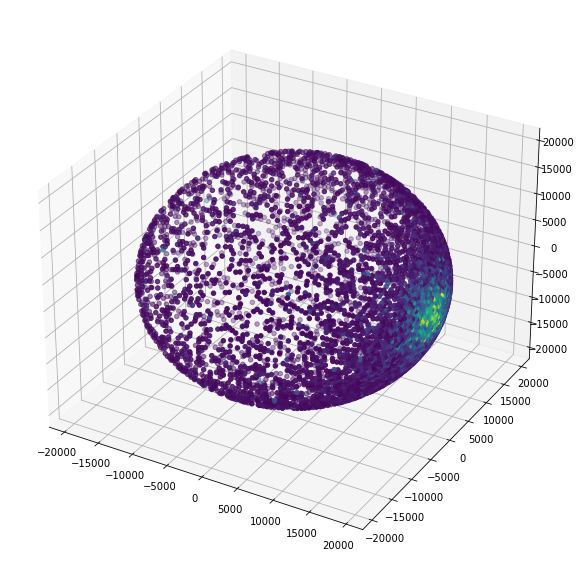

In [90]:
fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = ev_df['x_new'],
    ys = ev_df['y_new'],
    zs = ev_df['z_new'],
    c  = ev_df['charge']
)


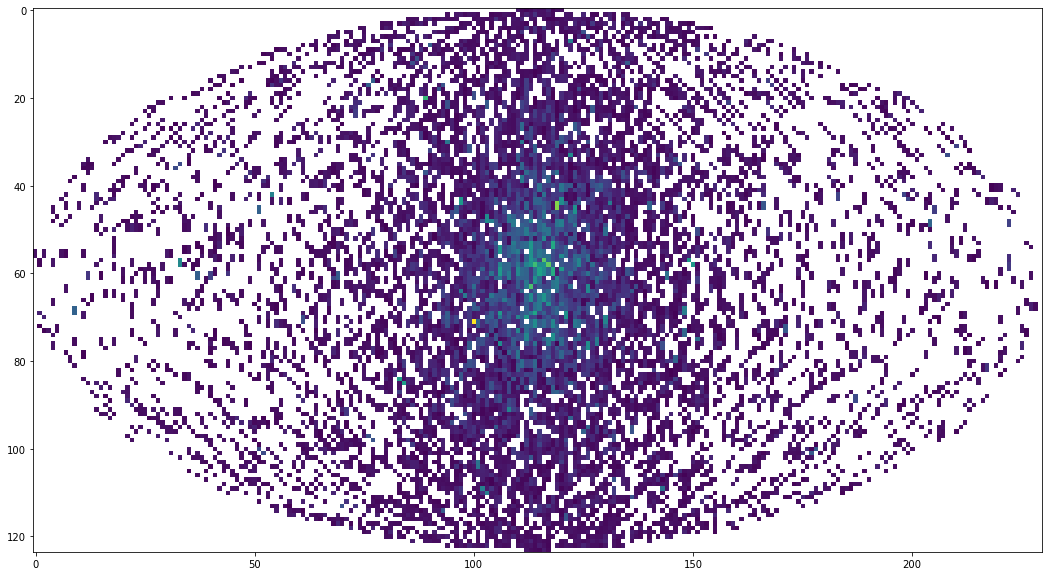

In [131]:
ev = 6

image = images_mat[ev, :, :, 0]
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
fig.savefig('prova.pdf')

In [134]:
error_ls

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [128]:
R

19432.033501196573